In [2]:
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras
import os



In [15]:



batch_size = 64
image_height = 512
image_width = 512


#
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../deployment/DATA/Training",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [16]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "../deployment/DATA/Training/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)   
val_images = []
val_labels = []

for images , labels in validation_dataset:
    val_images.append(images)
    val_labels.append(labels)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


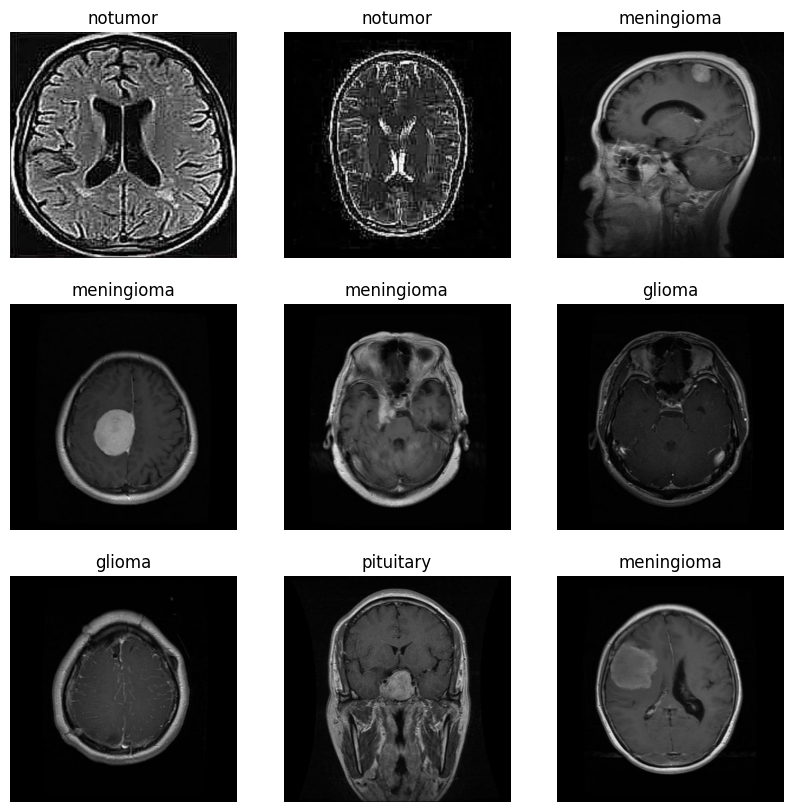

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 512, 512, 3)
(64,)


In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.9921569


In [34]:

AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),  # Increased filter size
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),  # Increased filter size
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),  # Added dropout layer
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Input(shape=(None, None, 3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),  # Increased filter size
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


# Learning Rate Scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.90,
    staircase=True)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [35]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=1,
)

C:\Users\ChipChaddleson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 9/72 [==>...........................] - ETA: 2:24 - loss: 132.2098 - accuracy: 0.3177

KeyboardInterrupt: 

In [ ]:
model.save("modelF1.keras")